In [1]:
from ISR.models import RRDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19
from ISR.utils.datahandler import DataHandler
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import cv2

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
lr_train_patch_size = 40
layers_to_extract = [5, 9]
scale = 4
hr_train_patch_size = lr_train_patch_size * scale

rrdn  = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_train_patch_size)
f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [2]:
lr_train_dir_4x = '/home/canrobins13/landsat_8/LR/train'
lr_train_dir_2x = '/home/canrobins13/landsat_8/LR_2x_not_tiled/train'
hr_train_dir = '/home/canrobins13/landsat_8/HR/train'

# data_handler = DataHandler(
#   lr_dir=lr_train_dir_4x,
#   hr_dir=hr_train_dir,
#   patch_size=lr_train_patch_size,
#   scale=scale,
# )

In [4]:
rrdn.model.load_weights('weights/rrdn-C4-D3-G64-G064-T10-x4/2019-12-06_0709/rrdn-C4-D3-G64-G064-T10-x4_best-val_generator_PSNR_epoch009.hdf5')

In [3]:
def adjust_gamma(img, gamma=1.0):
  img = (img * 255).astype(np.uint8)
  table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255
    for i in np.arange(0, 256)]).astype(np.uint8)

  return cv2.LUT(img, table)

In [15]:
def display_ims(lr4x, lr2x, hr, gamma=1.0):
  _, axs = plt.subplots(1, 3, figsize=(20, 12))
  axs = axs.flatten()

  print('\t     Low Resolution (4x) \t\t\t    Low Resolution (2x) \t\t\t Original Resolution')
  axs[0].imshow(adjust_gamma(lr4x, gamma=gamma))
  axs[1].imshow(adjust_gamma(lr2x, gamma=gamma))
  axs[2].imshow(adjust_gamma(hr, gamma=gamma))
  plt.show()

In [5]:
def get_ims(img_name='img_1.png', x1=400, y1=400, dx=100, dy=100, scale=4):
  lr_4x = plt.imread(os.path.join(lr_train_dir_4x, img_name))[x1:x1+dx, y1:y1+dx, :]
  lr_2x = plt.imread(os.path.join(lr_train_dir_2x, img_name))[x1*2 : (x1+dx)*2, y1*2 : (y1+dx)*2, :]
  hr = plt.imread(os.path.join(hr_train_dir, img_name))[x1*4 : (x1+dx)*4, y1*4 : (y1+dx)*4, :]
  
  return lr_4x, lr_2x, hr

In [7]:
ims = get_ims('img_2.png', x1=700, y1=700, dx=100, dy=100, scale=4)

	     Low Resolution (4x) 			    Low Resolution (2x) 			 Original Resolution


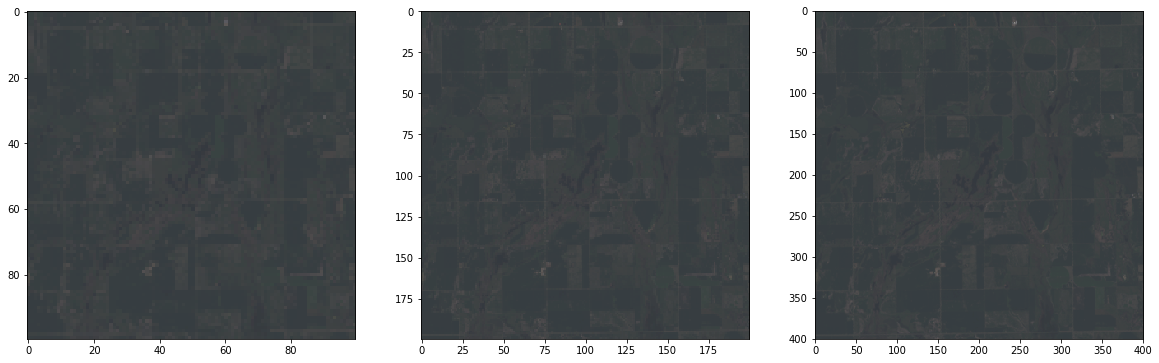

In [17]:
display_ims(*ims, gamma=1.5)

In [10]:
batch = data_handler.get_batch(batch_size=4, flatness=0.0)
sr = rrdn.model.predict(batch['lr']).clip(0, 1)

MemoryError: Unable to allocate array with shape (7845, 7721, 3) and data type float64

In [ ]:
i = 2
display_ims(sr[i], batch['lr'][i], batch['hr'][i], gamma=1.5)